In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
from download_images import acquire_data
import rasterio as rio
import json
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Acquire Data

In [7]:
bounds = "map.geojson"

acquisition = acquire_data(geom_file=bounds, name="home", data_dir="home", date_range="2023-01-15/2024-05-10")
acquisition.download_l8()
acquisition.download_l8pan()
# acquisition.download_s2()

100%|██████████| 6/6 [00:11<00:00,  1.86s/it]


# Call Model

In [5]:
# Load model directly
from transformers import AutoModel

ensembles = {
    "5depth-upsample":AutoModel.from_pretrained("venkatesh-thiru/s2l8h-UNet-5depth-upsample", trust_remote_code=True).eval().cuda(),
    "5depth-shuffle":AutoModel.from_pretrained("venkatesh-thiru/s2l8h-UNet-5depth-shuffle", trust_remote_code=True).eval().cuda(),
    "6depth-upsample":AutoModel.from_pretrained("venkatesh-thiru/s2l8h-UNet-6depth-upsample", trust_remote_code=True).eval().cuda(),
    "6depth-shuffle":AutoModel.from_pretrained("venkatesh-thiru/s2l8h-UNet-6depth-shuffle", trust_remote_code=True).eval().cuda()
}

# Read Images

In [2]:
l8MS_path = "/data/fast/venkatesh/Deep-Harmonization/inference/home/home/DN/L8/LC08_L2SP_143054_20230520_20230524_02_T1_SR.tif"
l8PAN_path = "/data/fast/venkatesh/Deep-Harmonization/inference/home/home/DN/L8_pan/LC08_L1TP_143054_20230520_20230524_02_T1.tif"
l8_mtl_path = "/data/fast/venkatesh/Deep-Harmonization/inference/home/home/DN/L8_pan/mtl/LC08_L1TP_143054_20230520_20230524_02_T1.json"

# Transform functions

In [16]:
def transform_l8ms(l8MS_path):
    raster = rio.open(l8MS_path, "r")
    print(raster)
    array = raster.read()
    array = array[:6]
    return array * 0.0000275 - 0.2

def transform_l8pan(l8PAN_path, l8_mtl_path):
    raster = rio.open(l8PAN_path, "r")
    array = raster.read()
    array = array[:6]
    meta = json.load(open(l8_mtl_path, "r"))

    meta = meta['LANDSAT_METADATA_FILE']['LEVEL1_RADIOMETRIC_RESCALING']
    return array * float(meta['REFLECTANCE_MULT_BAND_8'])+float(meta['REFLECTANCE_ADD_BAND_8'])


def extract_rgb(MS):
    MS = MS.detach().squeeze().cpu().numpy()
    MS = np.dstack([MS[2],MS[1],MS[0]])
    return MS

def plot_image(l8MS, l8up, suptitle = None):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 10))

    ax[0].imshow(extract_rgb(l8MS*3))
    ax[0].set_axis_off()
    ax[0].set_title("Bicubic")
    ax[1].imshow(extract_rgb(l8up*3))
    ax[1].set_axis_off()
    ax[1].set_title("Model")

    if not suptitle is None:
        plt.suptitle(suptitle)
        plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<open DatasetReader name='/data/fast/venkatesh/Deep-Harmonization/inference/home/home/DN/L8/LC08_L2SP_143054_20230520_20230524_02_T1_SR.tif' mode='r'>


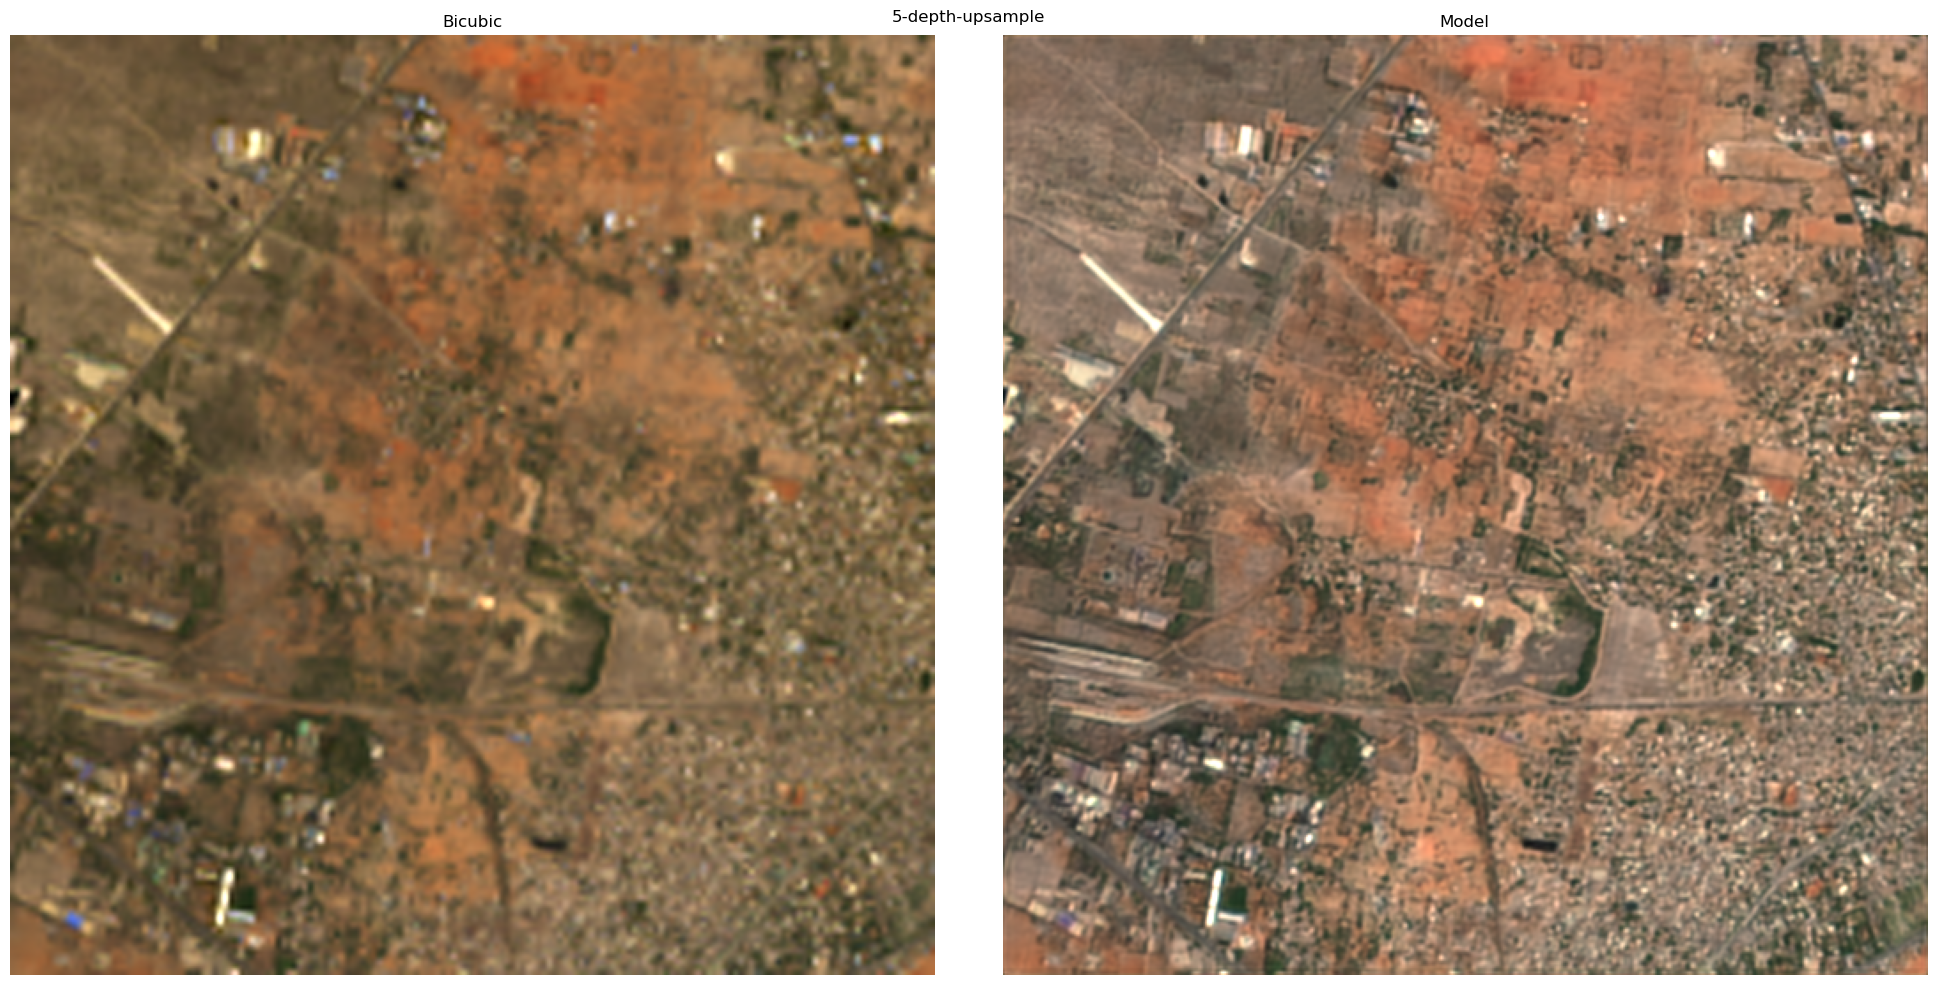

In [17]:
l8MS = torch.from_numpy(transform_l8ms(l8MS_path)).unsqueeze(dim=0).cuda()
l8MS = F.interpolate(l8MS, size=[l8MS.shape[-2]*3,l8MS.shape[-1]*3], mode="bicubic")

l8pan = torch.from_numpy(transform_l8pan(l8PAN_path, l8_mtl_path)).unsqueeze(dim = 0).cuda()
l8pan = F.interpolate(l8pan, size = l8MS.shape[2:], mode = "bicubic")

with torch.no_grad():
    l8up = ensembles['5depth-upsample'](l8MS, l8pan)
plot_image(l8MS, l8up, "5-depth-upsample")

## Ensembling the outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


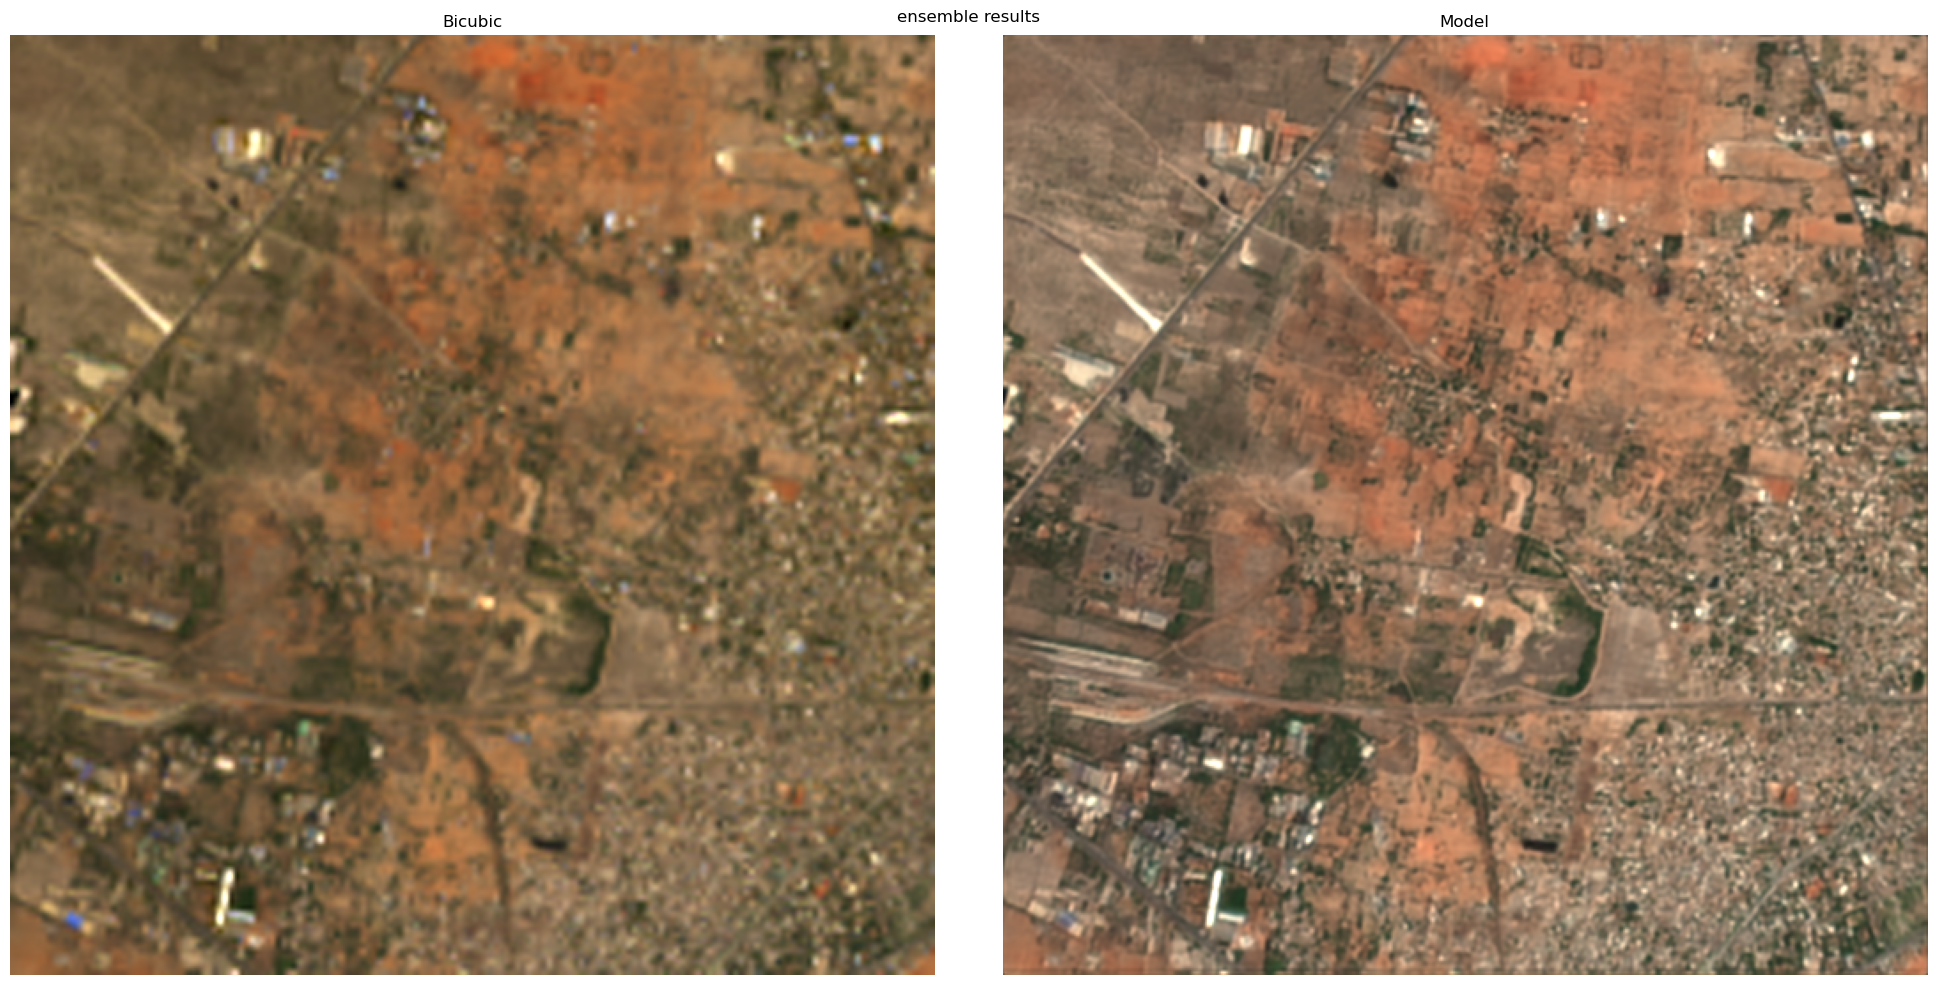

In [20]:
results = []
with torch.no_grad():
    for key in ensembles:
        results.append(ensembles[key](l8MS, l8pan))

ensemble_results = torch.cat(results)
plot_image(l8MS, torch.mean(ensemble_results, dim = 0), "ensemble results")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Variance (nir)')

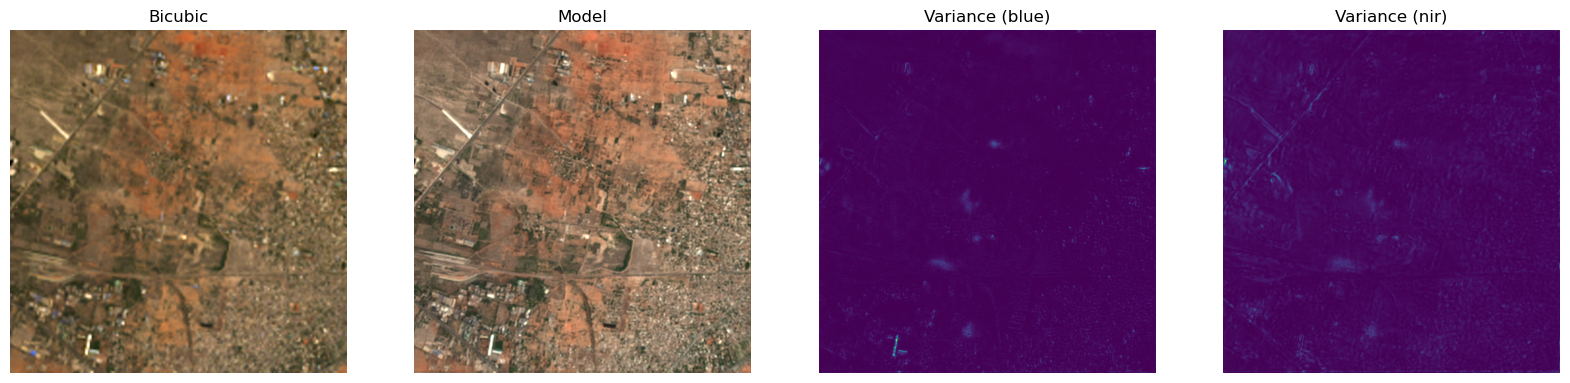

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (20, 10))

ax[0].imshow(extract_rgb(l8MS*3))
ax[0].set_axis_off()
ax[0].set_title("Bicubic")
ax[1].imshow(extract_rgb(torch.mean(ensemble_results, dim = 0)*3))
ax[1].set_axis_off()
ax[1].set_title("Model")
ax[2].imshow(torch.var(ensemble_results, dim = 0).detach().cpu().numpy()[0])
ax[2].set_axis_off()
ax[2].set_title("Variance (blue)")
ax[3].imshow(torch.var(ensemble_results, dim = 0).detach().cpu().numpy()[3])
ax[3].set_axis_off()
ax[3].set_title("Variance (nir)")